# Functional vs nonfunctional Lusy1 and Lusy2 arrays
This analysis takes merged CENH3 peaks (150 kb merging done to join discrete peaks) and centromeric satellites Lusy1 and Lusy2 (15kb merging to account for short array disruptions) and sorts centromeric satellite arrays to **functional arrays** (array overlaps with CENH3 units), **functional array fragments** (part of the array that overlaps with CENH unit), and **nonfuctional array** (array does not overlap CENH3 unit)

Statistics of these array subsets like size and count are then calculated and visualized.

Sequences of the array subset are extracted to be analysed for dyad symmetries and for dotplots.

In [1]:
import pybedtools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

## Sorting arrays

In [2]:
cenh3_path = 'data/chip-seq/consensus_peaks/CenH3_150k_merged_units.bed'
lusy1_path = 'data/satellites/Lusy1_merged_15k.bed'
lusy2_path = 'data/satellites/Lusy2_merged_15k.bed'
source_assembly = 'data/assembly/Lsyl.fasta'


In [3]:
cenh3 = pybedtools.BedTool(cenh3_path)
lusy1 = pybedtools.BedTool(lusy1_path)
lusy2 = pybedtools.BedTool(lusy2_path)

subsets = {}

subsets['lusy1_functional_arrays'] = lusy1.intersect(b=cenh3, wa=True).saveas('data/satellites/Lusy1_functional_arrays.bed')
subsets['lusy1_functional_fragments'] = lusy1.intersect(b=cenh3).saveas('data/satellites/Lusy1_functional_fragments.bed')
subsets['lusy1_nonfunctional_arrays'] = lusy1.intersect(b=cenh3, v=True).saveas('data/satellites/Lusy1_nonfunctional_arrays.bed')

subsets['lusy2_functional_arrays'] = lusy2.intersect(b=cenh3, wa=True).saveas('data/satellites/Lusy2_functional_arrays.bed')
subsets['lusy2_functional_fragments'] = lusy2.intersect(b=cenh3).saveas('data/satellites/Lusy2_functional_fragments.bed')
subsets['lusy2_nonfunctional_arrays'] = lusy2.intersect(b=cenh3, v=True).saveas('data/satellites/Lusy2_nonfunctional_arrays.bed')              


## Visualize array sizes 

In [4]:
def handle_units(num_list):
    if abs(num_list.max())+abs(num_list.min()) > 1_000_000:
        coeff = 1_000_000
        unit = 'Mb'
    elif abs(num_list.max())+abs(num_list.min()) > 1_000:
        coeff = 1_000
        unit = 'kb'
    else:
        coeff = 1
        unit = 'bp'
    return coeff, unit

lusy1_functional_arrays: 247 arrays, 274907.72 average length, 400900.01 std
lusy1_functional_fragments: 247 arrays, 189021.99 average length, 254293.34 std
lusy1_nonfunctional_arrays: 457 arrays, 20749.61 average length, 85296.14 std
lusy2_functional_arrays: 107 arrays, 237880.07 average length, 263695.38 std
lusy2_functional_fragments: 107 arrays, 94320.92 average length, 142935.36 std
lusy2_nonfunctional_arrays: 845 arrays, 20701.37 average length, 64977.28 std


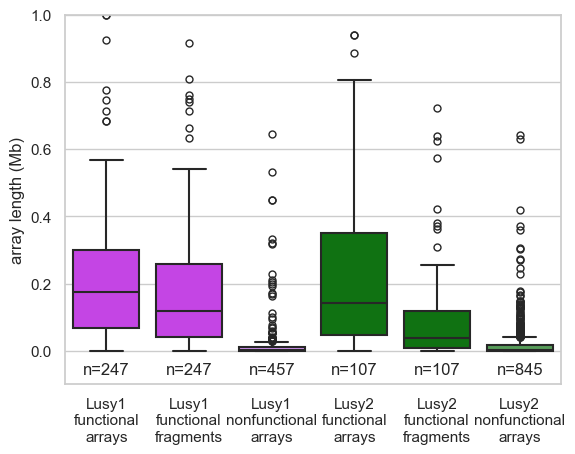

In [5]:
sizes_df = pd.DataFrame()

for subset_name in subsets:
    count = len(subsets[subset_name])
    array_lengths = [len(array) for array in subsets[subset_name]]
    sizes_df = pd.concat((sizes_df,pd.DataFrame({'subset': [subset_name]*count, 'length': array_lengths})))
    # report count, average size and standard deviation with 2 decimal places precision
    print(f'{subset_name}: {count} arrays, {sum(array_lengths)/count:.2f} average length, {np.std(array_lengths):.2f} std')

# handle units
coeff, unit = handle_units(sizes_df['length'])
sizes_df['length'] = sizes_df['length']/coeff

sns.set_theme(style="whitegrid")
# Set the default font family to Arial
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
short_labels= ['Lusy1\nfunctional\narrays', 'Lusy1\nfunctional\nfragments', 'Lusy1\nnonfunctional\narrays', 'Lusy2\nfunctional\narrays',
                 'Lusy2\nfunctional\nfragments', 'Lusy2\nnonfunctional\narrays']
colors = ['#d42afff1','#d42afff1', '#d481fff8', '#008203ff','#008203ff', '#4da84ff8']
sns.boxplot(data=sizes_df, x='subset', y='length', palette=colors, flierprops = dict(marker='o', fillstyle='none'))
plt.xticks(range(6), short_labels)
plt.xlabel('')
plt.ylim(-0.1, 1)
plt.ylabel(f'array length ({unit})')
# add counts to boxes
for i in range(6):
    count = len(sizes_df[sizes_df['subset']==sizes_df['subset'].unique()[i]])
    plt.text(i, -0.08, f'n={count}', horizontalalignment='center', verticalalignment='bottom')


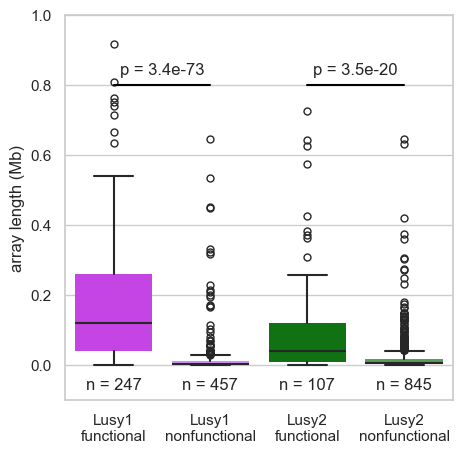

In [6]:
# calculate mann-whitney test between functional and nonfunctional arrays
lusy1_functional = sizes_df[sizes_df['subset']=='lusy1_functional_fragments']['length']
lusy1_nonfunctional = sizes_df[sizes_df['subset']=='lusy1_nonfunctional_arrays']['length']
lusy2_functional = sizes_df[sizes_df['subset']=='lusy2_functional_fragments']['length']
lusy2_nonfunctional = sizes_df[sizes_df['subset']=='lusy2_nonfunctional_arrays']['length']

# plot only functional fragments and nonfunctional arrays
plotted_subsets = ['lusy1_functional_fragments', 'lusy1_nonfunctional_arrays', 'lusy2_functional_fragments', 'lusy2_nonfunctional_arrays']
short_labels = ['Lusy1\nfunctional', 'Lusy1\nnonfunctional', 'Lusy2\nfunctional', 'Lusy2\nnonfunctional']
colors = ['#d42afff1', '#d481fff8', '#008203ff', '#4da84ff8']
plt.figure(figsize=(5,5))
sns.boxplot(data=sizes_df, x='subset', y='length', palette=colors, order=plotted_subsets, flierprops = dict(marker='o', fillstyle='none'),boxprops=dict(edgecolor='none'))
plt.xticks(range(4), short_labels)
plt.xlabel('')
plt.ylim(-0.1, 1)
plt.ylabel(f'array length ({unit})')
# add counts to boxes
for i in range(4):
    count = len(sizes_df[sizes_df['subset']==plotted_subsets[i]])
    plt.text(i, -0.08, f'n = {count}', horizontalalignment='center', verticalalignment='bottom')
# add mann-whitney test results
plt.plot([0,1], [0.8, 0.8], color='black')
plt.text(0.5, 0.82, f'p = {stats.mannwhitneyu(lusy1_functional, lusy1_nonfunctional)[1]:.1e}', horizontalalignment='center', verticalalignment='bottom')
plt.plot([2,3], [0.8, 0.8], color='black')
plt.text(2.5, 0.82, f'p = {stats.mannwhitneyu(lusy2_functional, lusy2_nonfunctional)[1]:.1e}', horizontalalignment='center', verticalalignment='bottom')

plt.savefig('data/figures/array_sizes_box.svg', dpi=300, bbox_inches='tight')


## Extract sequences

In [9]:
for subset_name in subsets:
    subsets[subset_name].sequence(fi=source_assembly).save_seqs(f'data/functional_arrays/{subset_name}.fasta')

## Create moddotplots


```bash
cd data/functional_arrays/moddotplots
cd ..
name="lusy2_functional_fragments"
echo ">${name}" > ${name}_concat.fasta && grep -v '^>' ${name}.fasta  >> ${name}_concat.fasta
awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < ${name}_concat.fasta > ${name}_flat.fasta


source ~/Documents/ModDotPlot/venv/bin/activate
cd moddotplots
moddotplot -i ../${name}_flat.fasta
```

## Dyad symmetries
see notebook [array_nonB_structures.ipynb](array_nonB_structures.ipynb)